## Comparison of theoretical and simulated SFs

In this document we simulate the data using Bill's algorithm: simulate the signal in Fourier domain with given PSD, turn it to time domain signal with inverse Fourier transform.

In [1]:
import os
import math
import scipy
import random
#import mjdtools
import numpy as np
import matplotlib.pyplot as plt
import scipy.special
import colorednoise as cn

### Section 1
Introducing the SF functions (non-averaged and averaged)

In [41]:
#introducing functions to calculate the SFs
#the SF function calculates the SF between all the pairs of data
def SF(data, time, err):
    Len=len(data)
    SF_list=[]
    diff_time=[]
    err_list=[]
    for j in range(Len):
        if j+1<Len:
            for i in range(j+1, Len):
#here it is calculated: time difference and SF values
                diff_time=np.append(diff_time, abs(time[i]-time[j]))
                SF_list=np.append(SF_list, (data[i]-data[j])**2)
                err_list=np.append(err_list, np.sqrt(err[i]**2+err[j]**2))
        else:
            break
    return diff_time, SF_list, err_list
#this is the function, which averages the SF values calculated with SF function
#give as input number of bins Nbin
def SF_aver(time_lag, time, SF, Nbin, err, bin_t="log"):
#Sf is averaged on log scale: np.sort(np.log10(time_lag))
    if bin_t=="log":
        diff_time_s, SF_list_s=np.sort(np.log10(time_lag)), SF_list[np.argsort(time_lag)]
        min_t=np.log10(np.mean(np.diff(time)))
    if bin_t=="lin":
        diff_time_s, SF_list_s=time_lag, SF_list
        min_t=min(diff_time_s)
    diff_SF=diff_time_s
#splitting the whole range of times in equal intervals (in log scale)
    bin_list=np.array([(max(diff_time_s)-min_t)/Nbin*j for j in range(Nbin+1)])
    SF_new=[]
    timel_av=[]
    diff_SF_av=[]
    list_time_new=[]
    for j in range(len(bin_list)-1):
        SF_new=[]
        list_time_new=[]
        for i in range(len(diff_SF)):
            if diff_SF[i]>=bin_list[j] and diff_SF[i]<bin_list[j+1]:
                list_time_new.append(diff_SF[i])
                SF_new.append(SF_list_s[i])
        if list_time_new!=[]:
            timel_av=np.append(timel_av, np.mean(list_time_new))
            diff_SF_av=np.append(diff_SF_av, np.mean(SF_new))
    return timel_av, diff_SF_av, err_list

### Section 2
Actual data simulation. Here I am using Bill's algorithm

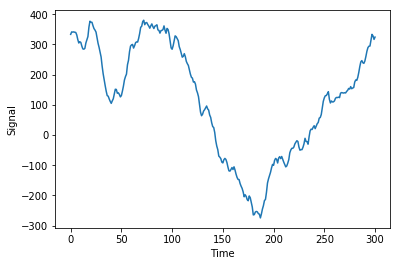

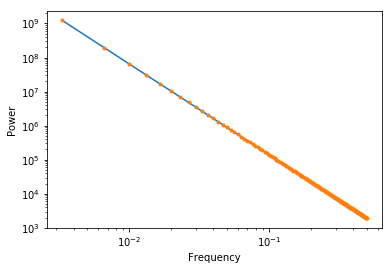

In [76]:
#data simulation block
#lambda from Emmanolopulos is a
a=8/3.
#time stemps
Len=301
time_list=np.arange(0., Len, 1)
#frequency stemps, corresponding to time stemps
f=np.fft.fftfreq(Len, 1)
pos_f = np.array([x for x in f if x > 0])
#the shape of PSD spectrum (after equation B11 from Emmanolopuolos)
PSD_sim=pos_f**(-a)*Len
A_sim=np.sqrt(PSD_sim)
phi=np.random.uniform(0, 2*math.pi, len(pos_f)) #random phase
z_sim_positive=A_sim*np.exp(1j*phi)
z_sim_negative=np.flip(A_sim*np.exp(-1j*phi))
#not sure about the first element of the Fourier
z_0=np.array([1.0*A_sim[0]])
z_sim=np.append(np.append(z_0, z_sim_positive), z_sim_negative)
list_signal=np.real(np.fft.ifft(z_sim))
cov=np.diag([0.0**2 for i in range(len(time_list))])
mean=[0. for i in range(len(time_list))]
err=np.array([100.**2 for i in range(len(time_list))])
list_signal=list_signal+np.random.multivariate_normal(mean, cov)
plt.plot(list_signal)
plt.ylabel("Signal")
plt.xlabel("Time")
plt.show()
#import colorednoise as cn
#list_signal_cn=cn.powerlaw_psd_gaussian(a, 301)
PSD_result=abs(np.fft.fft(list_signal))**2
#PSD_result_cn=abs(np.fft.fft(list_signal_cn))**2
#the generated and theoretical PSDs are the same
plt.plot(pos_f, PSD_result[1:len(pos_f)+1])
#plt.plot(f, PSD_result_cn[1:int(len(list_signal)/2+1)])
plt.plot(pos_f, PSD_sim, ".")
plt.xscale("log")
plt.yscale("log")
plt.ylabel("Power")
plt.xlabel("Frequency")
plt.show()

### Section 3
Calculating theoretical SF and SF from the simulated data

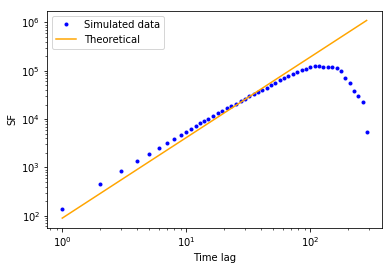

In [78]:
#calculate SF from the data
diff_time, SF_list, err_list=SF(list_signal, time_list, err)
diff_time_s, SF_list_s, err_list_s=np.sort(diff_time), SF_list[np.argsort(diff_time)], err_list[np.argsort(diff_time)]
time_av, SF_av, err_av=SF_aver(diff_time, time_list, SF_list, 70, err_list)

#theoretical structure function (according to equation B11 from Emmanoupulos)
coeff2=-2.**(a)*math.pi**(a-1)*np.sin(a*math.pi/2.)*math.gamma(1-a)
SF_theor=coeff2*(10**time_av)**(a-1)

plt.plot(10**time_av, SF_av, ".", label="Simulated data", c="blue")
#plt.plot(10**time_av, SF_av2, ".")
plt.plot(10**time_av, SF_theor,label="Theoretical", c="orange")
plt.xscale("log")
plt.yscale("log")
plt.ylabel("SF")
plt.xlabel("Time lag")
plt.legend()
#plt.show()

### Section 4
Creating large dataset, split it in N subdatasets and average N SFs

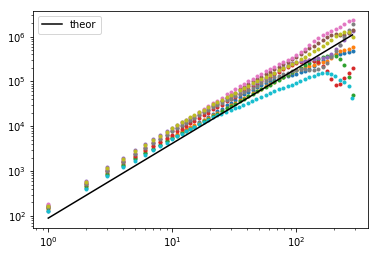

In [56]:
#data simulation block
#lambda from Emmanolopulos is a
#a=8/3 for Kolmogorov noise
a=8./3
#time stemps
sub_data=301
Len=10*sub_data
time_list=np.arange(0., Len, 1)
#frequency stemps, corresponding to time stemps
f=np.fft.fftfreq(Len, 1)[1:int(len(time_list)/2)]
err=np.array([1.**2 for i in range(len(time_list))])
#the shape of PSD spectrum (after equation B11 from Emmanolopuolos)
PSD_sim=f**(-a)*Len
A_sim=np.sqrt(PSD_sim)
phi=np.random.uniform(0, 2*math.pi, len(f)) #random phase
z_sim_positive=A_sim*np.exp(1j*phi)
z_sim_negative=np.flip(A_sim*np.exp(-1j*phi))
#not sure about the first element of the Fourier
z_0=np.array([A_sim[0]])
z_sim=np.append(np.append(z_0, z_sim_positive), z_sim_negative)
list_signal=np.real(np.fft.ifft(z_sim))
for k in range(10):

	#calculate SF from the data
	diff_time, SF_list, err_list=SF(list_signal[k*sub_data:(k+1)*sub_data], time_list[k*sub_data:(k+1)*sub_data], err)
	time_av, SF_av, err_av=SF_aver(diff_time, time_list, SF_list, 70, err_list)

	#theoretical structure function (according to equation B11 from Emmanoupulos)
	coeff2=-2.**(a)*math.pi**(a-1)*np.sin(a*math.pi/2.)*math.gamma(1-a)
	SF_theor=coeff2*(10**time_av)**(a-1)

	plt.plot(10**time_av, SF_av, ".")
	#plt.plot(10**time_av, SF_av2, ".")
plt.plot(10**time_av, SF_theor, "black", label="theor")
plt.legend()
plt.xscale("log")
plt.yscale("log")

### Section 5
Creating long time series, split it in subchunks, calculate the SFs of each subchunck and average

In [105]:
#data simulation block
#lambda from Emmanolopulos is a
#a=8/3 for Kolmogorov noise
a=8./3
#time stemps
sub_data=301
nsubs=50
Len=50*sub_data
binSF=70
time_list=np.arange(0., Len, 1)
#frequency stemps, corresponding to time stemps
f=np.fft.fftfreq(Len, 1)[1:int(len(time_list)/2)]
err=np.array([1.**2 for i in range(len(time_list))])
#the shape of PSD spectrum (after equation B11 from Emmanolopuolos)
PSD_sim=f**(-a)
A_sim=np.sqrt(PSD_sim)
phi=np.random.uniform(0, 2*math.pi, len(f)) #random phase
z_sim_positive=A_sim*np.exp(1j*phi)
z_sim_negative=np.flip(A_sim*np.exp(-1j*phi))
#not sure about the first element of the Fourier
z_0=np.array([A_sim[0]])
z_sim=np.append(np.append(z_0, z_sim_positive), z_sim_negative)
list_signal=np.real(np.fft.ifft(z_sim))
for k in range(nsubs):
    #calculate SF from the data
    diff_time, SF_list, err_list=SF(list_signal[k*sub_data:(k+1)*sub_data], time_list[k*sub_data:(k+1)*sub_data], err)
    time_av, SF_av, err_av=SF_aver(diff_time, time_list, SF_list, binSF, err_list)
    if k==0:
        SF_global_av=SF_av
    else:
        SF_global_av=SF_global_av+SF_av
SF_global_av=SF_global_av/nsubs
#theoretical structure function (according to equation B11 from Emmanoupulos)
coeff2=-2.**(a)*math.pi**(a-1)*np.sin(a*math.pi/2.)*math.gamma(1-a)
SF_theor=coeff2*(10**time_av)**(a-1)

Text(0.5,0,'Time lag')

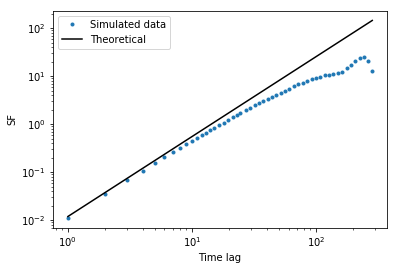

In [109]:
plt.plot(10**time_av, SF_av, ".", label="Simulated data")
#plt.plot(10**time_av, SF_av2, ".")
plt.plot(10**time_av, SF_theor/Len*2, "black", label="Theoretical")
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.ylabel("SF")
plt.xlabel("Time lag")

### Section 6
Creating long time series, split it in subchunks, calculate the SFs of each subchunck and average. Checking other slopes

In [110]:
#data simulation block
#lambda from Emmanolopulos is a
#a=8/3 for Kolmogorov noise
a=5./3
#time stemps
sub_data=301
nsubs=30
Len=30*sub_data
binSF=70
time_list=np.arange(0., Len, 1)
#frequency stemps, corresponding to time stemps
f=np.fft.fftfreq(Len, 1)[1:int(len(time_list)/2)]
err=np.array([1.**2 for i in range(len(time_list))])
#the shape of PSD spectrum (after equation B11 from Emmanolopuolos)
PSD_sim=f**(-a)
A_sim=np.sqrt(PSD_sim)
phi=np.random.uniform(0, 2*math.pi, len(f)) #random phase
z_sim_positive=A_sim*np.exp(1j*phi)
z_sim_negative=np.flip(A_sim*np.exp(-1j*phi))
#not sure about the first element of the Fourier
z_0=np.array([A_sim[0]])
z_sim=np.append(np.append(z_0, z_sim_positive), z_sim_negative)
list_signal=np.real(np.fft.ifft(z_sim))
for k in range(nsubs):
    #calculate SF from the data
    diff_time, SF_list, err_list=SF(list_signal[k*sub_data:(k+1)*sub_data], time_list[k*sub_data:(k+1)*sub_data], err)
    time_av, SF_av, err_av=SF_aver(diff_time, time_list, SF_list, binSF, err_list)
    if k==0:
        SF_global_av=SF_av
    else:
        SF_global_av=SF_global_av+SF_av
SF_global_av=SF_global_av/nsubs
#theoretical structure function (according to equation B11 from Emmanoupulos)
coeff2=-2.**(a)*math.pi**(a-1)*np.sin(a*math.pi/2.)*math.gamma(1-a)
SF_theor=coeff2*(10**time_av)**(a-1)

Text(0.5,0,'Time lag')

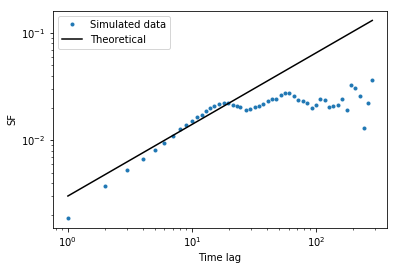

In [111]:
plt.plot(10**time_av, SF_av, ".", label="Simulated data")
#plt.plot(10**time_av, SF_av2, ".")
plt.plot(10**time_av, SF_theor/Len*2, "black", label="Theoretical")
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.ylabel("SF")
plt.xlabel("Time lag")